Using the attached dataset, please create a notebook (preferably Python but any tool is allowed) to explore the data in order to answer questions like:
+ **How would you make a geo expansion recommendation?**
+ **What new columns would you create?**
+ **How might clustering analysis help - how would you go about it?**

However, use these questions just as a starting point, and feel free to also use your own creativity/inspiration

In the interview process, we'll ask you to take us through your notebook, thought process and the libraries that you've used. A presentation/deck of any kind is not necessary.

[Metadata](https://carto.com/spatial-data-catalog/browser/dataset/acs_sociodemogr_f7ba0b77/data)

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import contextily as ctx

import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from sklearn import cluster
import libpysal
import geoplot as gplt

In [2]:

#loading provided dataset
df = pd.read_excel('./US Census Dataset.xlsx')
df.head()


ID  total_pop  male_pop  female_pop  pop_25_years_over  median_age  \
0   0      48970     24123       24847              26944        27.0   
1   1        809       376         433                612        56.2   
2   2       2330      1198        1132               1650        46.0   
3   3      22171     11234       10937              15022        38.3   
4   4       2829      1485        1344               2033        41.2   

   median_income  income_per_capita  gini_index  median_rent  black_pop  \
0        51972.0            21486.0      0.3620        853.0      16810   
1        29087.0            21153.0      0.4452        370.0        127   
2        56400.0            29967.0      0.4528        533.0        276   
3        73226.0            30397.0      0.4187       1297.0        377   
4        35064.0            20576.0      0.4633        481.0         41   

   hispanic_pop  white_pop                                               geom  
0         11761      14301  MULTIPOLYGON(((-97.874316 31.077931, -97.87367...  
1            31        651  POLYGON((-95.793207 32.036901, -95.805474 32.0...  
2           254       1691  POLYGON((-79.073703 35.659202, -79.074482 35.6...  
3         11256       8195  POLYGON((-121.71859 36.814383, -121.715383 36....  
4            21       2727  POLYGON((-81.587423 37.749221, -81.595335 37.7...

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33120 entries, 0 to 33119
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 33120 non-null  int64  
 1   total_pop          33120 non-null  int64  
 2   male_pop           33120 non-null  int64  
 3   female_pop         33120 non-null  int64  
 4   pop_25_years_over  33120 non-null  int64  
 5   median_age         32553 non-null  float64
 6   median_income      30956 non-null  float64
 7   income_per_capita  32478 non-null  float64
 8   gini_index         32211 non-null  float64
 9   median_rent        27018 non-null  float64
 10  black_pop          33120 non-null  int64  
 11  hispanic_pop       33120 non-null  int64  
 12  white_pop          33120 non-null  int64  
 13  geom               33120 non-null  object 
dtypes: float64(5), int64(8), object(1)
memory usage: 3.5+ MB


In [4]:
df.columns

Index(['ID', 'total_pop', 'male_pop', 'female_pop', 'pop_25_years_over',
       'median_age', 'median_income', 'income_per_capita', 'gini_index',
       'median_rent', 'black_pop', 'hispanic_pop', 'white_pop', 'geom'],
      dtype='object')

In [5]:
#sns.boxplot(data=df[['gini_index']])         

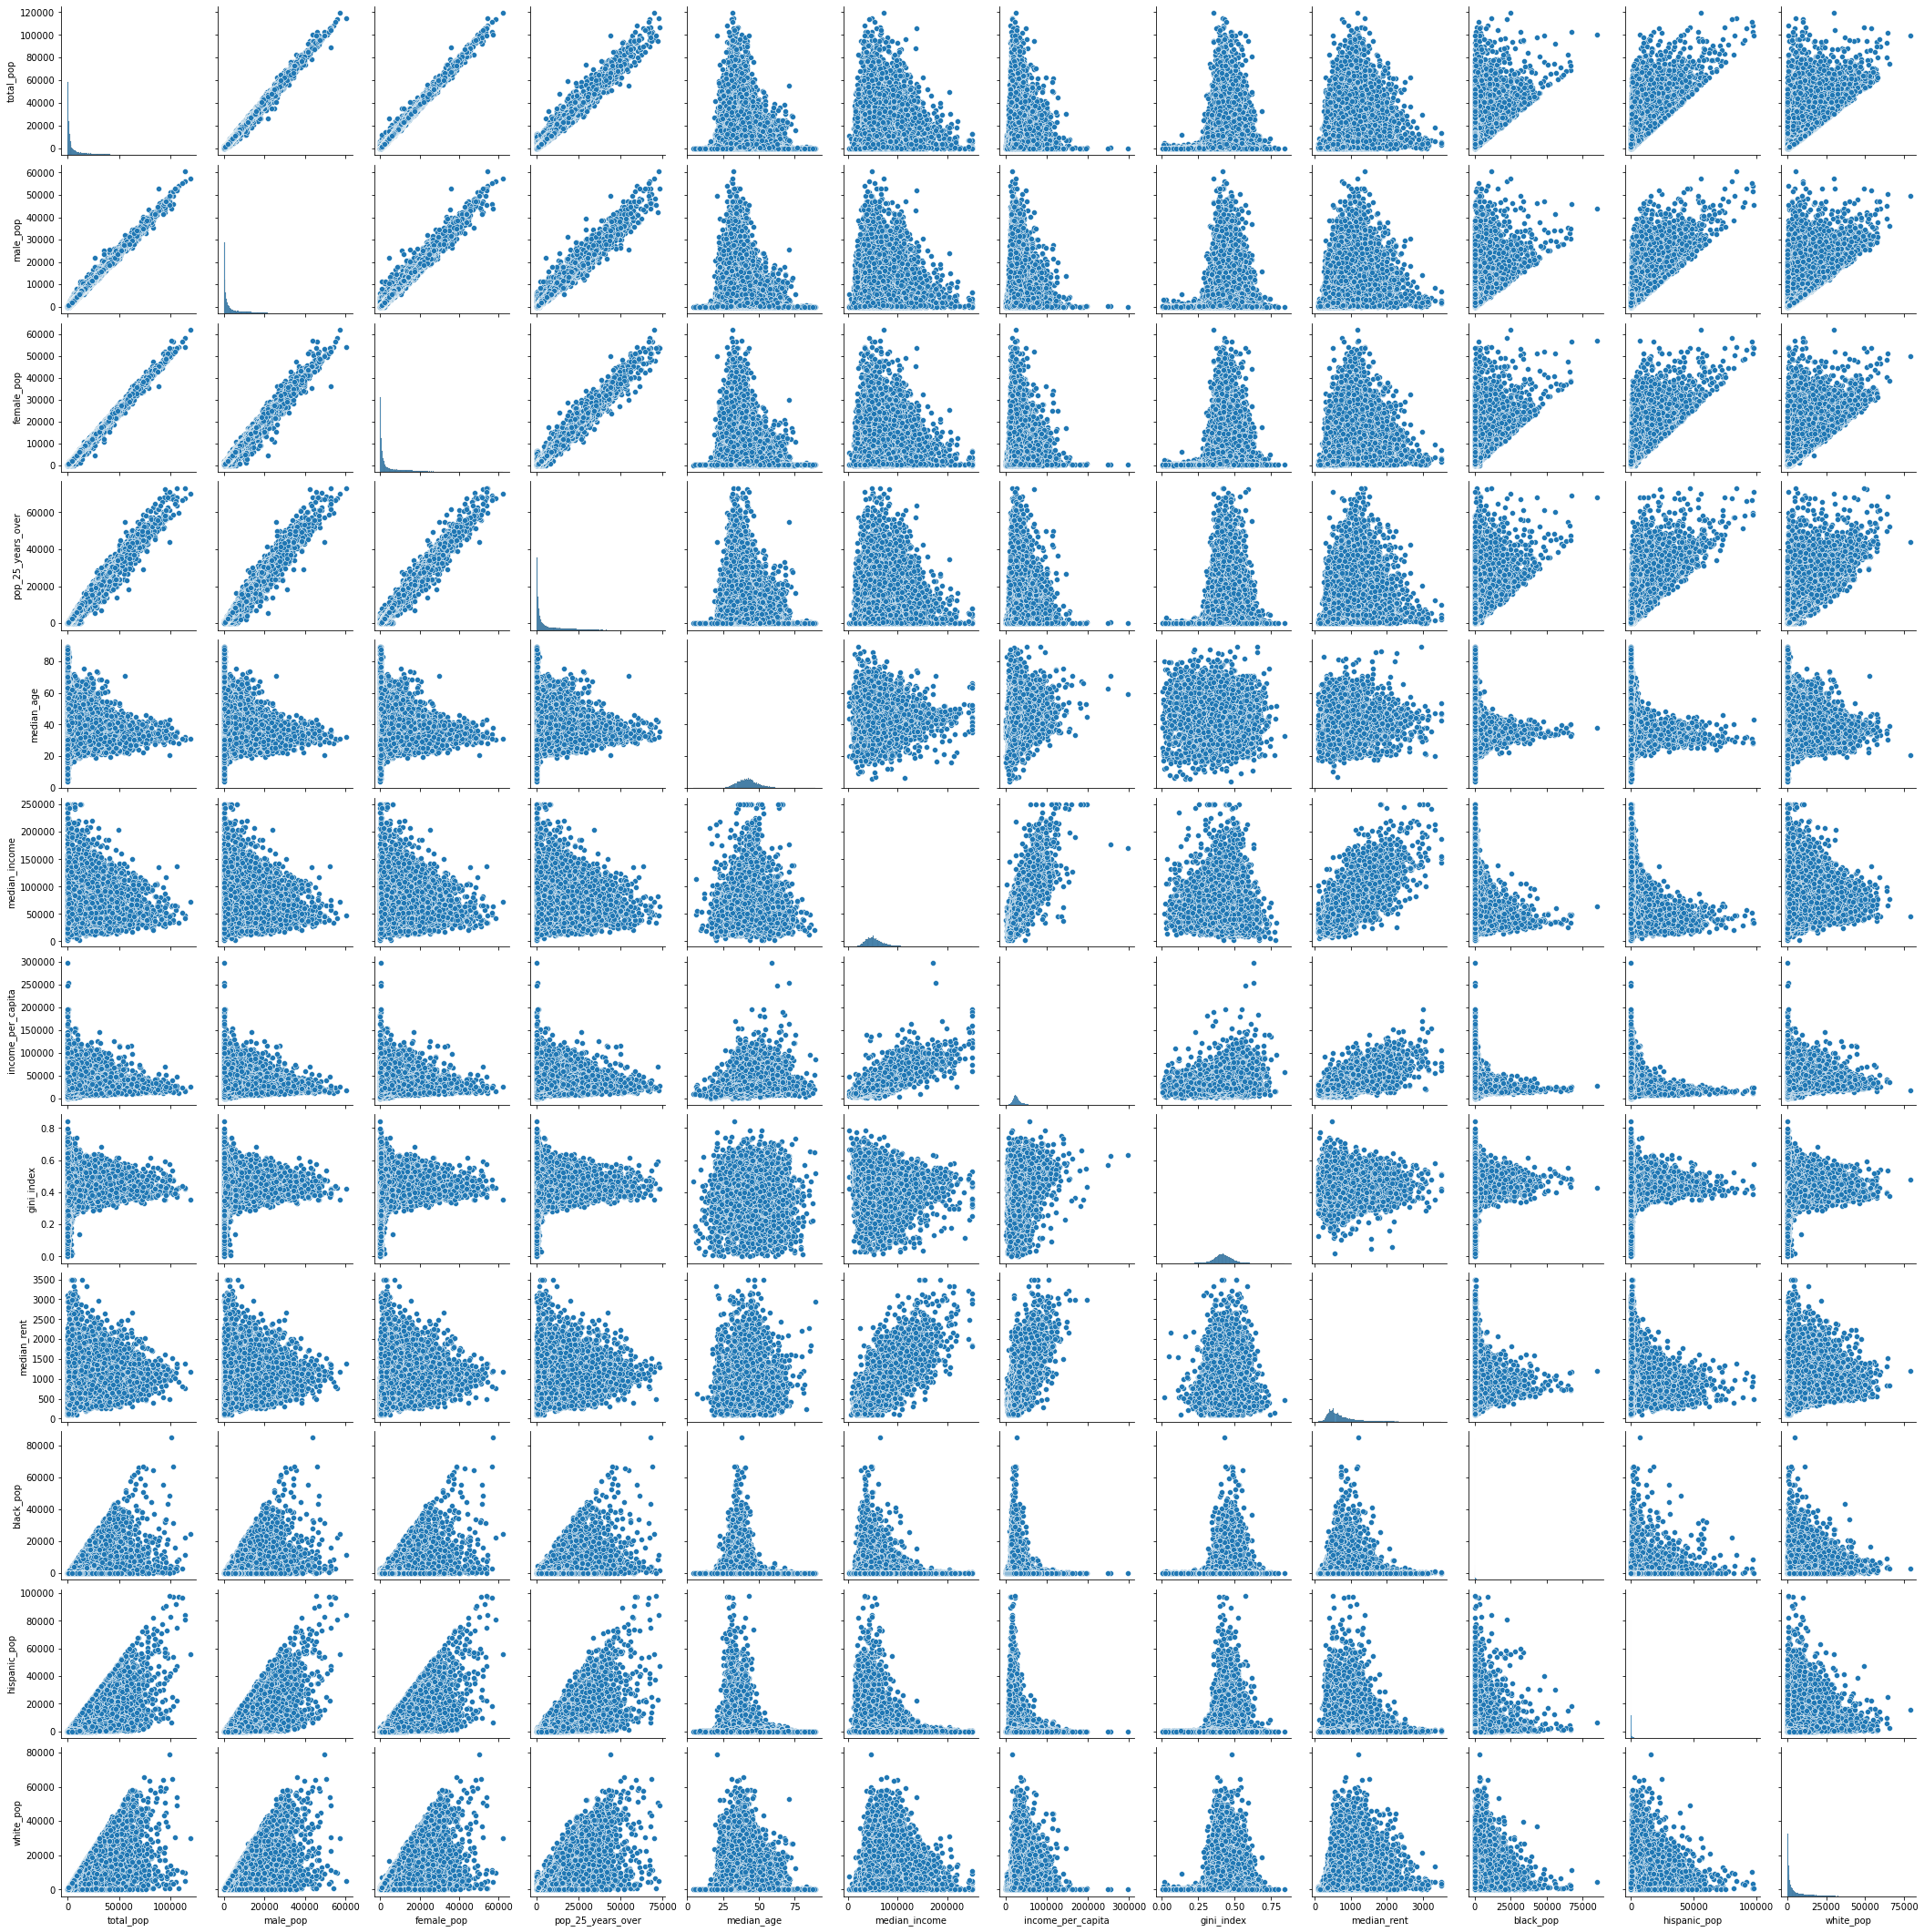

In [6]:
# Create the default pairplot - check if there's any obvious correlation
sns.pairplot(df[['total_pop', 'male_pop', 'female_pop', 'pop_25_years_over',
       'median_age', 'median_income', 'income_per_capita', 'gini_index',
       'median_rent', 'black_pop', 'hispanic_pop', 'white_pop']])

### GIS

In [7]:
#Checking geometry + viz
#creating geodataframe

Creating GeoDataFrame using conventional way throws an error, which indicates that there are issues with WKT

```python
gdf = gpd.GeoDataFrame(df, geometry=df['geom'])
```
Looking at the data in QGIS, the assumption that there are extra numbers (or numbers removed from a pair) which distorts geometry
<img src="./images/qgis_wkt_issue.PNG" alt="qgis_wkt_issue" width="600"/>

In [8]:
#Fixing geomertry using shapely
from shapely import wkt

geom = []

for g in df['geom']:
    try:
        geom.append(wkt.loads(g))
    except:
        geom.append(None)

df['geometry'] = geom

ParseException: Expected number but encountered end of stream
ParseException: Expected number but encountered word: '-'
ParseException: Expected number but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected

ParseException: Expected number but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected number but encountered end of stream


In [9]:
#chekcing for empty geometries
df["geometry"].isna().sum()

139

In [10]:
df.dropna(subset=['geometry'], inplace=True)

In [11]:
gdf = gpd.GeoDataFrame(df, geometry=df['geometry'])
#CRS check
print(gdf.crs)

None


<AxesSubplot:>

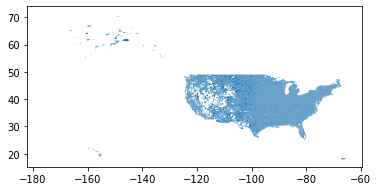

In [12]:
#quick check that data looks OK
gdf.plot()

In [13]:
#As this data covers US and is US cencus NAD83 or WGS84 coudl be used (differences will not have effect on this scale)
# setting CRS to WGS84 to avoid possilbe CRS conversions later if/when adding addtional datasets

gdf.set_crs(epsg=4326, inplace=True)
gdf.head()

ID  total_pop  male_pop  female_pop  pop_25_years_over  median_age  \
0   0      48970     24123       24847              26944        27.0   
1   1        809       376         433                612        56.2   
2   2       2330      1198        1132               1650        46.0   
3   3      22171     11234       10937              15022        38.3   
4   4       2829      1485        1344               2033        41.2   

   median_income  income_per_capita  gini_index  median_rent  black_pop  \
0        51972.0            21486.0      0.3620        853.0      16810   
1        29087.0            21153.0      0.4452        370.0        127   
2        56400.0            29967.0      0.4528        533.0        276   
3        73226.0            30397.0      0.4187       1297.0        377   
4        35064.0            20576.0      0.4633        481.0         41   

   hispanic_pop  white_pop                                               geom  \
0         11761      14301  MULTIPOLYGON(((-97.874316 31.077931, -97.87367...   
1            31        651  POLYGON((-95.793207 32.036901, -95.805474 32.0...   
2           254       1691  POLYGON((-79.073703 35.659202, -79.074482 35.6...   
3         11256       8195  POLYGON((-121.71859 36.814383, -121.715383 36....   
4            21       2727  POLYGON((-81.587423 37.749221, -81.595335 37.7...   

                                            geometry  
0  MULTIPOLYGON (((-97.87432 31.07793, -97.87367 ...  
1  POLYGON ((-95.79321 32.03690, -95.80547 32.035...  
2  POLYGON ((-79.07370 35.65920, -79.07448 35.660...  
3  POLYGON ((-121.71859 36.81438, -121.71538 36.8...  
4  POLYGON ((-81.58742 37.74922, -81.59534 37.742...

C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\contextily\tile.py:583: RuntimeWarning: divide by zero encountered in log2
  zoom_lon = np.ceil(np.log2(360 * 2.0 / lon_length))


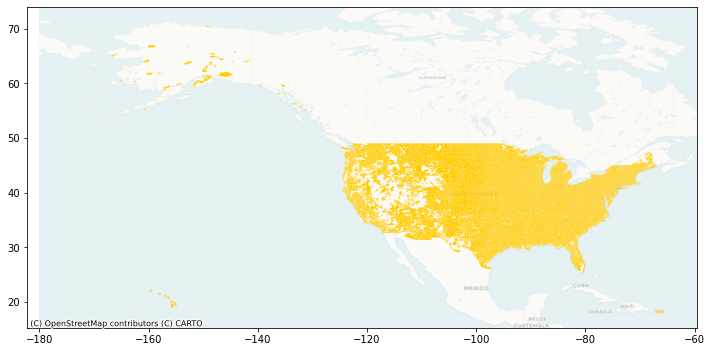

In [14]:
#Better visualisaton with some background mapping


fig, ax = plt.subplots(figsize=(12,8))

# Plot the data
#os_data.plot(ax=ax)
gdf.plot(color = '#ffcc00',ax=ax)
# Add basemap

ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.CartoDB.Voyager, alpha = 0.6)

#Even better interactive mapping

map = folium.Map(location = [30.266666,-97.733330], tiles = "OpenStreetMap", zoom_start = 10)

for _, r in df.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,style_function=lambda x: {'color': '#ffcc00'})
    geo_j.add_to(map)
map

VISUALISATIONS

In [15]:
#creating polygon centroids to use them for clustering

centr = gdf.copy()
#going to centroids

centr['geometry'] = centr['geometry'].to_crs(epsg=5070).centroid

In [17]:
#adding new data

usa = gpd.read_file("data/cb_2018_us_state_20m.shp")
usa.head()

STATEFP   STATENS     AFFGEOID GEOID STUSPS          NAME LSAD  \
0      24  01714934  0400000US24    24     MD      Maryland   00   
1      19  01779785  0400000US19    19     IA          Iowa   00   
2      10  01779781  0400000US10    10     DE      Delaware   00   
3      39  01085497  0400000US39    39     OH          Ohio   00   
4      42  01779798  0400000US42    42     PA  Pennsylvania   00   

          ALAND       AWATER  \
0   25151100280   6979966958   
1  144661267977   1084180812   
2    5045925646   1399985648   
3  105828882568  10268850702   
4  115884442321   3394589990   

                                            geometry  
0  MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...  
1  POLYGON ((-96.62187 42.77925, -96.57794 42.827...  
2  POLYGON ((-75.77379 39.72220, -75.75323 39.757...  
3  MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...  
4  POLYGON ((-80.51989 40.90666, -80.51964 40.987...

In [18]:
#check crs
usa.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [19]:
centr.to_crs(epsg=4326,inplace=True)
usa.to_crs(epsg=4326,inplace=True)

In [20]:
centr1=centr.dropna(subset=['income_per_capita'])

Text(0.5, 1.0, 'Census data shown as income per capita ')

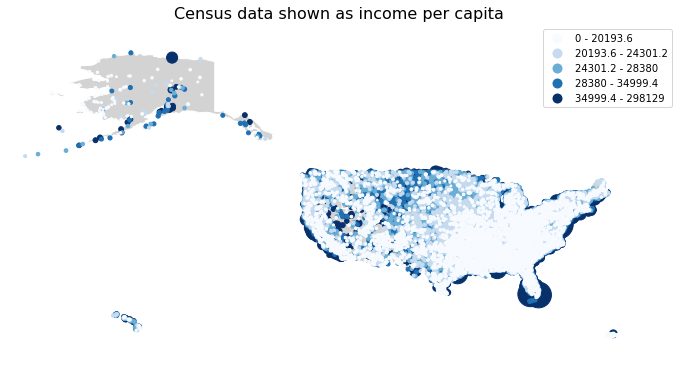

In [30]:
ax = gplt.polyplot(
  usa,
  edgecolor="white",
  facecolor="lightgray",
  figsize=(12, 8) 
 # projection=gplt.crs.AlbersEqualArea()
)

gplt.pointplot(
  centr1,
  ax=ax,
  hue="income_per_capita",
  cmap="Blues",
  scheme="quantiles",
  scale="income_per_capita",
  limits=(1, 30),
  legend=True,legend_var='hue'
)

ax.set_title("Census data shown as income per capita ", fontsize=16)

In [22]:
fgdf = centr[['female_pop','geometry']]
mgdf = centr[['male_pop','geometry']]

C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\seaborn\distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)


<AxesSubplot:>

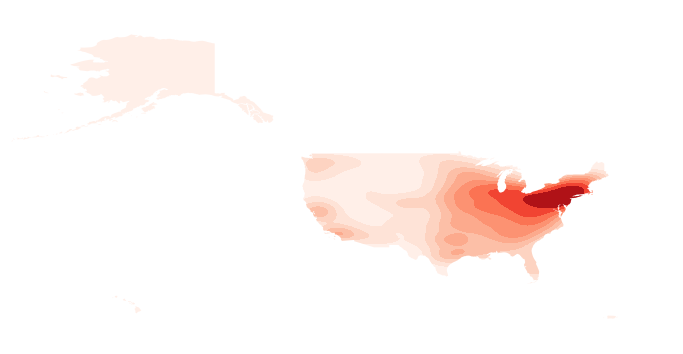

In [33]:
ax = gplt.polyplot(usa,
  edgecolor="white",
  facecolor="lightgray",
  figsize=(12, 8) )
gplt.kdeplot(fgdf, cmap="Reds", shade=True, thresh=0,  clip=usa, ax=ax)


C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\seaborn\distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)


<AxesSubplot:>

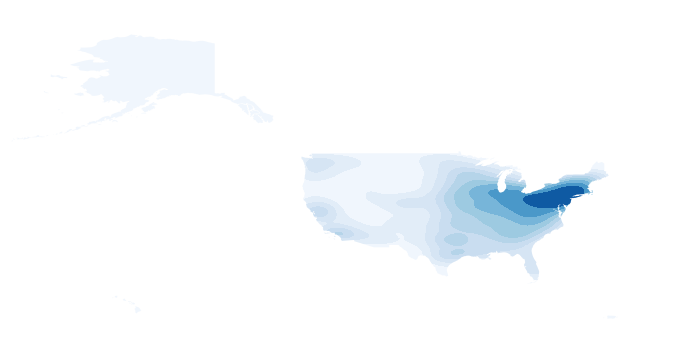

In [32]:
ax = gplt.polyplot(usa,
  edgecolor="white",
  facecolor="lightgray",
  figsize=(12, 8) )
gplt.kdeplot(mgdf, cmap="Blues",  shade=True, shade_lowest=True, clip=usa, ax=ax)

# Variable viz

## Choropleth mapping to visually investigate data

In [34]:
ethnic_groups = ['black_pop', 'hispanic_pop', 'white_pop']

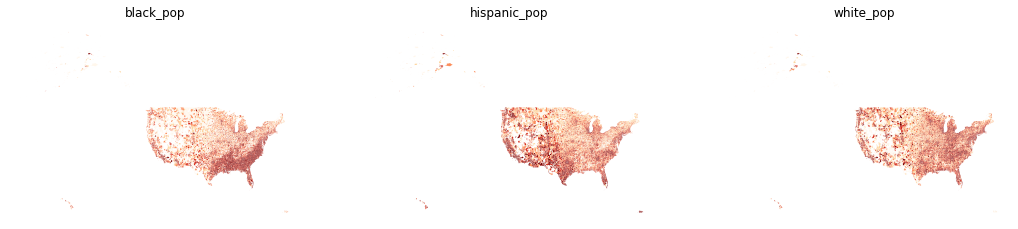

In [35]:
# Create figure and axes 
f, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start the loop over all the ethnic_groups
for i, col in enumerate(ethnic_groups):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    gdf.plot(column=col, ax=ax, scheme='Quantiles', linewidth=0, cmap='OrRd')
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()


## Target users 

 This [data](https://www.statista.com/statistics/310344/us-online-dating-app-site-usage-age/) suggests that main users off dating apps are  _**18 - 44**_
 

<AxesSubplot:>

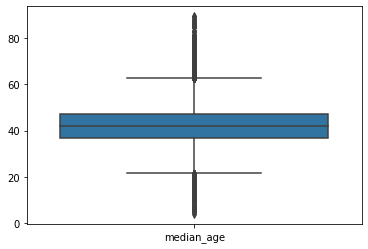

In [36]:
#Median age distribution in a data
sns.boxplot(data=df[['median_age']])

In [37]:
#Simplistic way
#extract only specific age group - this is our target group
#check where those people live

gdf_18_45 = gdf.loc[(gdf['median_age'] >= 18) & (df['median_age'] <45) ]

In [38]:
#subselecting above average median income to subselect those who could afford premium features

gdf_18_45_high_inc = gdf_18_45.loc[(gdf_18_45['median_income'] >=  gdf_18_45['median_income'].mean()) ]

In [39]:
#selecting dominant ethnic group from three present groups
gdf_18_45_high_inc['dominant_ethnic_group'] = gdf_18_45_high_inc[['black_pop', 'hispanic_pop', 'white_pop']].idxmax(axis=1)

C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [40]:
# minimising dataset by dissolving boundaries based on the value
# dissolve the state boundary by region 
dominant_group = gdf_18_45_high_inc.dissolve(by='dominant_ethnic_group')

<AxesSubplot:>

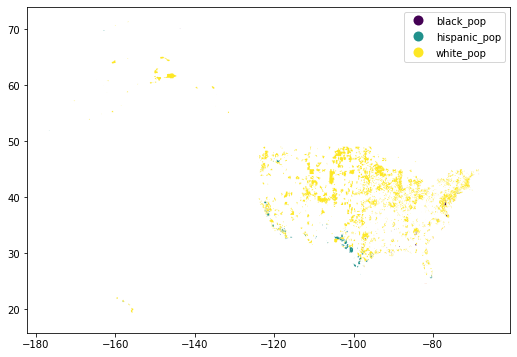

In [41]:
 # create the plot
fig, ax = plt.subplots(figsize = (10,6))
# plot the data 
dominant_group.reset_index().plot(column = 'dominant_ethnic_group',cmap ='viridis',legend=True, ax=ax)
 

In [42]:
#creating polygon centroids to use them for clustering

gdf_18_45_high_inc_centroids = gdf_18_45_high_inc.copy()

# change geometry + projecting data
gdf_18_45_high_inc_centroids['geometry'] = gdf_18_45_high_inc_centroids['geometry'].to_crs(epsg=5070).centroid

### _Summary_
I would target clearly visible  **Cluster**    with prelevant hispanic population :
+ they are concentrated/ clustered
+ on a higher then average income
+ target age group


Cluster ( white population) is wide spread, so further refinement is needed

Cluster  ( black population) is less wide spread than Cluster 1, but still could be refined

## Spatial Clustering

Looking at the dominant ethnic distribution the complete spatial randomness/null hypotheses could be discarded
https://learning.oreilly.com/library/view/cluster-analysis-5th/9780470978443/chapter02.html#c02anchor-2


Attribute similarity - location similarity

In [43]:
#trying 3 clusters 

kmeans3 = cluster.KMeans(n_clusters=3)
k3cls = kmeans3.fit(gdf_18_45_high_inc[ethnic_groups])
gdf_18_45_high_inc['k3cls'] = k3cls.labels_

C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


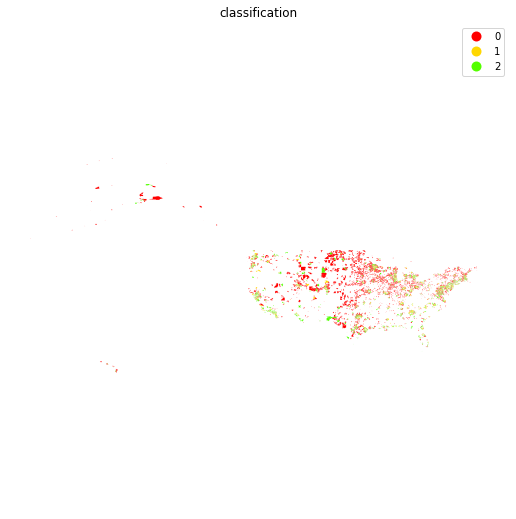

In [44]:
## Mapping the categories

# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
gdf_18_45_high_inc.plot(column='k3cls', categorical=True,cmap='prism', legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('classification')
# Display the map
plt.show()

In [45]:
#trying 6 clusters (not going to a higher number to avoid 'spatial' singletones)

kmeans6 = cluster.KMeans(n_clusters=6)
k6cls = kmeans6.fit(gdf_18_45_high_inc[ethnic_groups])
gdf_18_45_high_inc['k6cls'] = k6cls.labels_

C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


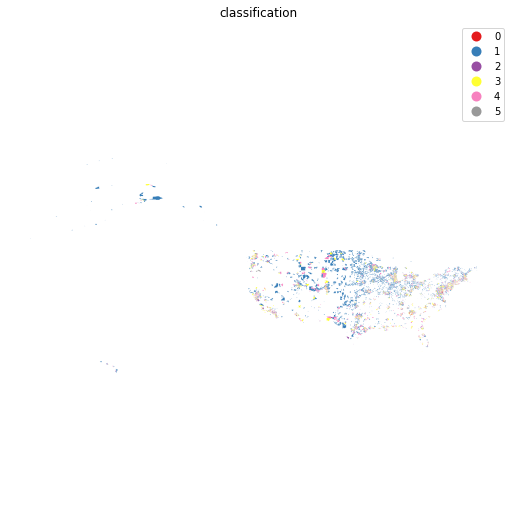

In [46]:
## Mapping the categories

# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
gdf_18_45_high_inc.plot(column='k6cls', categorical=True,cmap='Set1', legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('classification')
# Display the map
plt.show()

In [47]:
#Viz to show clusters on a separate plot

In [48]:
clusters = gdf_18_45_high_inc['k3cls'].unique()
clusters1 = gdf_18_45_high_inc['k6cls'].unique()

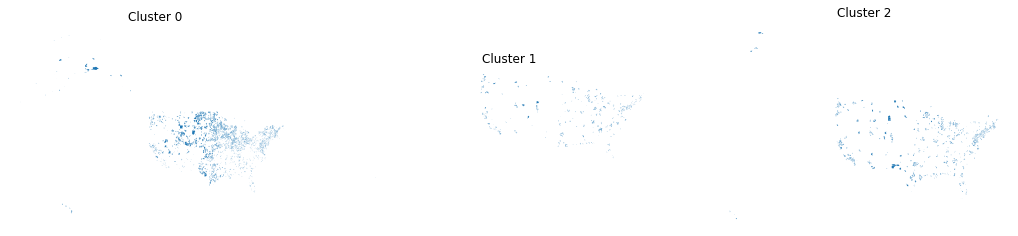

In [49]:
# Create figure and axes 
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
# Make the axes accessible with single indexing
axs = axs.flatten()

for i in clusters:
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    gdf_18_45_high_inc.loc[(gdf_18_45_high_inc['k3cls']==i)].plot(ax=ax)
   
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title('Cluster '+str(i))
# Display the figure
plt.show()

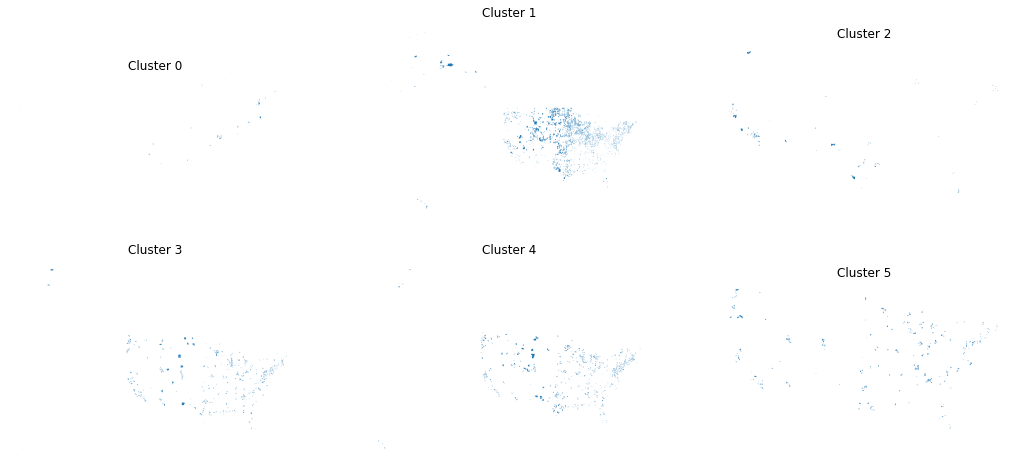

In [50]:
# Create figure and axes 
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
# Make the axes accessible with single indexing
axs = axs.flatten()

for i in clusters1:
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    gdf_18_45_high_inc.loc[(gdf_18_45_high_inc['k6cls']==i)].plot(ax=ax)
   
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title('Cluster '+str(i))
# Display the figure
plt.show()


In [51]:
#gdf_18_45_high_inc[['black_pop', 'hispanic_pop', 'white_pop','k3cls','k6cls','geometry']]

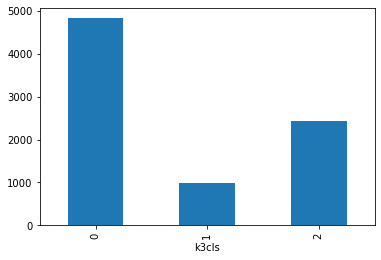

In [52]:
#number of elements in a subgroup:
k3sizes = gdf_18_45_high_inc.groupby('k3cls').size()
_ = k3sizes.plot(kind='bar')


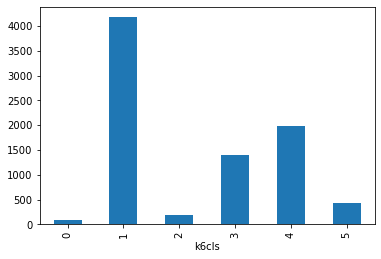

In [53]:
#number of elements in a subgroup:
k6sizes = gdf_18_45_high_inc.groupby('k6cls').size()
_ = k6sizes.plot(kind='bar')

In [54]:

# Calculate the mean by group
k3means = gdf_18_45_high_inc.groupby('k3cls')[ethnic_groups].mean()
# Show the table transposed (so it's not too wide)
k3means.T

k3cls                   0             1             2
black_pop      477.444721   3009.536145   2434.135468
hispanic_pop   590.366936   5541.993976   5306.465107
white_pop     3365.244555  32620.346386  16291.381773

In [55]:

# Calculate the mean by group
k6means = gdf_18_45_high_inc.groupby('k6cls')[ethnic_groups].mean()
# Show the table transposed (so it's not too wide)
k6means.T

k6cls                    0            1             2             3  \
black_pop     25015.558140   220.373023   4522.417582   2140.539511   
hispanic_pop   5668.767442   425.099665  31256.642857   3849.964799   
white_pop      9727.360465  2558.519645  15443.901099  23517.589799   

k6cls                    4             5  
black_pop      1481.956038   3232.127273  
hispanic_pop   2731.295099   5858.093182  
white_pop     12249.237494  38852.693182

In [56]:
cl6_ethn = gdf_18_45_high_inc[['black_pop', 'hispanic_pop', 'white_pop']].rename(lambda x: str(int(x)))\
                          .assign(cl=k6cls.labels_)\
                          .groupby('cl')\
                          .mean()
cl6_sex = gdf_18_45_high_inc[[ 'male_pop', 'female_pop']].rename(lambda x: str(int(x)))\
                          .assign(cl=k6cls.labels_)\
                          .groupby('cl')\
                          .mean()

In [57]:
cl3_ethn = gdf_18_45_high_inc[[ 'black_pop', 'hispanic_pop', 'white_pop']].rename(lambda x: str(int(x)))\
                          .assign(cl=k3cls.labels_)\
                          .groupby('cl')\
                          .mean()
cl3_sex = gdf_18_45_high_inc[[ 'male_pop', 'female_pop']].rename(lambda x: str(int(x)))\
                          .assign(cl=k3cls.labels_)\
                          .groupby('cl')\
                          .mean()

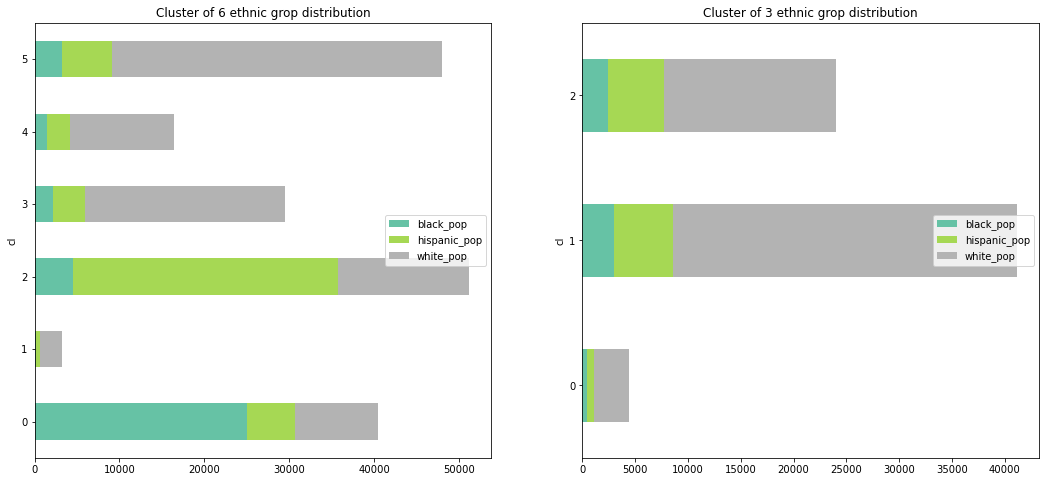

In [58]:
fig, (ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

cl6_ethn.plot(kind='barh', stacked=True, ax=ax1 ,cmap='Set2', linewidth=0)
ax1.legend(ncol=1, loc="right");
ax1.title.set_text('Cluster of 6 ethnic grop distribution')
 
cl3_ethn.plot(kind='barh', stacked=True, ax=ax2 ,cmap='Set2', linewidth=0)
ax2.legend(ncol=1, loc="right");
ax2.title.set_text('Cluster of 3 ethnic grop distribution')

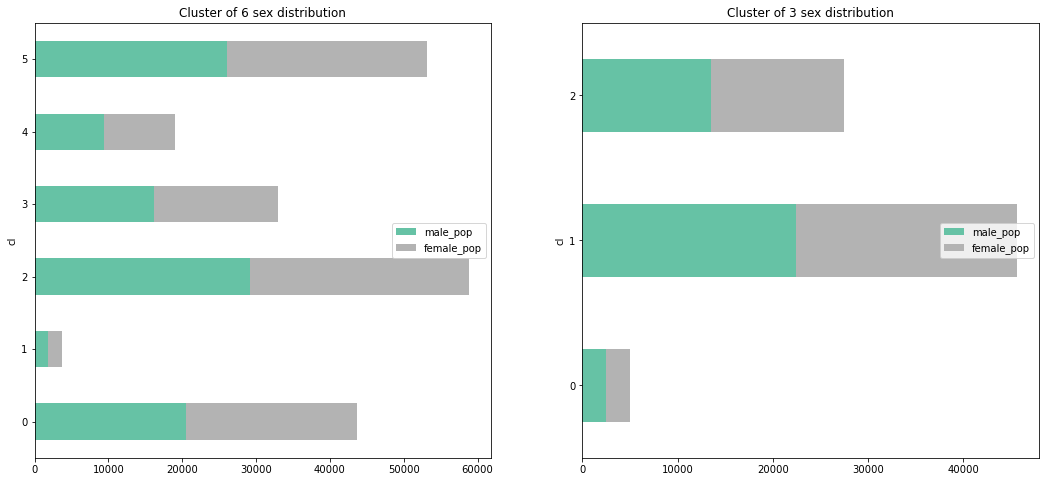

In [59]:
fig, (ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

cl6_sex.plot(kind='barh', stacked=True, ax=ax1,cmap='Set2', linewidth=0)
ax1.legend(ncol=1, loc="right");
ax1.title.set_text('Cluster of 6 sex distribution')

cl3_sex.plot(kind='barh', stacked=True, ax=ax2, cmap='Set2', linewidth=0)
ax2.legend(ncol=1, loc="right");
ax2.title.set_text('Cluster of 3 sex distribution')

## Summary 

+ Cluster #  in group of 6 shows prevailing  black population  with even F/M split
+ Cluster #  in group of 6 shows prevailing  hispanic population  with even F/M split
+ Cluster #  in group of 6 shows prevailing  white population  with even F/M split

Extra data/variables woudl benefit clusterisation


#### Ways to improve

1. weighted optimization 
* between attributes similarity and spatial characteristics ( clusters on  coordinates)
* to ensure contiguity 
+ by adding weights to coordinates (_w1_) and other attributes (_w2_)



## State - level expansion

In [60]:
#creating centroids of main gdf
centroids_all = gdf.copy()
centroids_all['geometry'] = centroids_all['geometry'].centroid

C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


In [61]:
#removeing geom column to keep data tidy
centroids_all.drop(columns='geom',inplace = True)

In [62]:
#centroids_all.columns

In [63]:
centroids_all.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [64]:
# Make a spatial join + projecting both datasets
join_gdf = gpd.sjoin(centroids_all.to_crs(epsg=5070), usa.to_crs(epsg=5070), how="inner", op="within")

In [65]:
#join_gdf.head()

In [66]:
#join_gdf.to_file("usa_centroids_joined.shp")

In [67]:
#mean rent and income by state
rent_income = join_gdf.groupby('NAME')['median_rent','median_income'].mean().reset_index().sort_values(by='median_rent')

C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [68]:
#Let's join GeoDataFrame usa with DataFrame rent_income based on state
rent_income_usa = pd.merge(rent_income, usa, on='NAME')

In [69]:
from splot.mapping import vba_choropleth

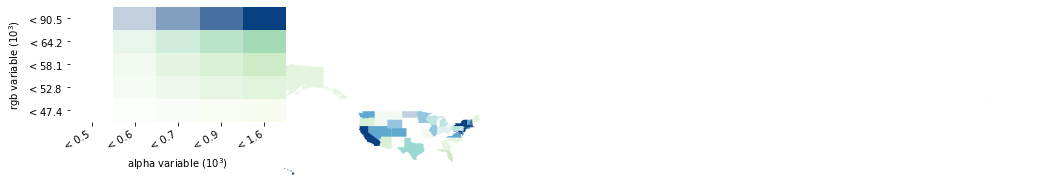

In [70]:
fig1 = plt.figure(figsize=(15,8))
ax = fig1.add_subplot(111)
vba_choropleth( rent_income_usa['median_income'].values, 
               rent_income_usa['median_rent'].values, 
               rent_income_usa,
               alpha_mapclassify=dict(classifier='quantiles', k=5),
               rgb_mapclassify=dict(classifier='quantiles', k=5),
               legend=True,
               ax=ax)
plt.show()

### _Summary_

Darker coloured states are those with  the high averaged of median_income by state

Transparency indicates the averaged median rent by the state

In [71]:
#top 10 
rent_income.sort_values(by=['median_income','median_rent'], ascending=False).iloc[0:10]

NAME  median_rent  median_income
30            New Jersey  1250.631776   90503.021053
8   District of Columbia  1554.333333   86625.416667
6            Connecticut  1057.581967   86145.520755
20              Maryland  1122.646893   85278.103211
21         Massachusetts  1082.240664   82165.825243
40          Rhode Island   903.940299   73705.305556
29         New Hampshire   892.190909   72435.278689
4             California  1220.753111   68780.077586
32              New York   915.669188   67921.100724
11                Hawaii  1172.691358   66766.809524

# Areas with dominant females

In [72]:
#using same age-group -above average income dataframe

gdf_18_45_high_inc['fm_ratio'] = gdf_18_45_high_inc['female_pop']/gdf_18_45_high_inc['male_pop']

C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [73]:
max_ratio = gdf_18_45_high_inc['fm_ratio'].max()

In [74]:
max_df = gdf_18_45_high_inc.loc[(gdf_18_45_high_inc['fm_ratio']==max_ratio)] 


In [75]:
#Some interactive mapping to see where the highest ratio of F/M is

map = folium.Map(location = [max_df.centroid.y, max_df.centroid.x], tiles = "OpenStreetMap", zoom_start = 12)

C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


In [76]:
folium.GeoJson(max_df["geometry"],style_function=lambda x: {'color': '#ffcc00'}).add_to(map)
map

In [77]:
#and dominant F areas

min_df = gdf_18_45_high_inc.loc[(gdf_18_45_high_inc['fm_ratio']== gdf_18_45_high_inc['fm_ratio'].min())] 

In [78]:
map = folium.Map(location = [min_df.centroid.y, min_df.centroid.x], tiles = "OpenStreetMap", zoom_start = 10)
folium.GeoJson(min_df["geometry"],style_function=lambda x: {'color': '#ffcc00'}).add_to(map)
map

C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


## Gini index

The Gini coefficient is based on the comparison of cumulative proportions of the population against cumulative proportions of income they receive, and it ranges between 0 in the case of perfect equality and 1 in the case of perfect inequality.

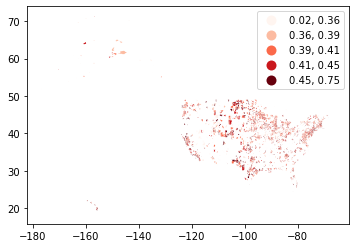

In [79]:
gdf_18_45_high_inc.plot(column='gini_index', cmap='Reds', scheme='quantiles',legend=True);


In [80]:
bins = [0.1, 0.25, 0.5, 0.75]
labels=['Least deprived', 'Moderatly deprived','Highly deprived']
gdf_18_45_high_inc['gini_binned'] = pd.cut(gdf_18_45_high_inc['gini_index'], bins=bins, labels=labels)

C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [81]:
least_depr_gdf = gdf_18_45_high_inc.loc[(gdf_18_45_high_inc['gini_binned']=='Least deprived')]

In [82]:
map = folium.Map(location =[38.67867,-100.75297], tiles = "OpenStreetMap", zoom_start = 4)
folium.GeoJson(least_depr_gdf["geometry"],style_function=lambda x: {'color': '#ffcc00'}).add_to(map)
map

In [83]:
#As space is not limited to 'artificial' statistical boundaries, another approach would be 
# create centroid of a  statistical unit
# create buffer around it to allow uniform geometries

least_depr_gdf.to_crs(epsg=5070,inplace=True)

C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [84]:
buffer = least_depr_gdf.buffer(5000)#, cap_style = 3)

Now lets exclude rural areas using Urban areas [dataset](https://www2.census.gov/geo/tiger/TIGER2017//UAC/tl_2017_us_uac10.zip)
assuming that target users will be urban residents - educated young professionals


In [85]:
urban = gpd.read_file('./data/tl_2017_us_uac10.shp')

In [86]:
urban.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

#dont run - takes ages

folium.GeoJson(least_depr_gdf["geometry"],style_function=lambda x: {'color': '#ffcc00'}).add_to(map)

folium.GeoJson(buffer,style_function=lambda x: {'color': 'red'}).add_to(map)

folium.GeoJson(urban,style_function=lambda x: {'color': 'brown'}).add_to(map)

map

#takes anormous time to run 


least_deprived_urban = gpd.clip(buffer,urban.to_crs(epsg=5070))

In [87]:
#alternative faster way
buffer.to_file('./data/buffer.shp')

run the following command in cmd to clip files
```
ogr2ogr -clipsrc urban.shp least_deprived_urban1.shp buffer.shp  

ogr2ogr -f "ESRI Shapefile" -t_srs EPSG:5070 -s_srs EPSG:4269 urban.shp tl_2017_us_uac10.shp
```

In [88]:
least_deprived_urban = gpd.read_file('./data/least_deprived_urban1.shp')

In [92]:
map1 = folium.Map(location =[38.67867,-100.75297], tiles = "OpenStreetMap", zoom_start = 4)
folium.GeoJson(least_deprived_urban,style_function=lambda x: {'color': 'blue'}).add_to(map1)
#folium.GeoJson(urban,style_function=lambda x: {'color': 'brown', 'fill_opacity':0.2}).add_to(map1)
map1